# Imports

In [1]:
import numpy as np
import tensorflow as tf
from neuraxle.api import DeepLearningPipeline
from neuraxle.base import ExecutionContext, DEFAULT_CACHE_FOLDER
from neuraxle.hyperparams.space import HyperparameterSamples
from neuraxle.pipeline import Pipeline
from neuraxle.steps.numpy import OneHotEncoder
from neuraxle.steps.output_handlers import OutputTransformerWrapper

from data_reading import load_data
from neuraxle_tensorflow.tensorflow_v1 import TensorflowV1ModelStep
from plotting import plot_metric
from steps.forma_data import FormatData

# Load Data

In [2]:
data_inputs, expected_outputs = load_data()

Some useful info to get an insight on dataset's shape and normalisation:
(data_inputs shape, expected_outputs shape, every data input mean, every data input standard deviation)
(7352, 128, 9) (7352, 1) 0.10206611 0.40216514
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


# Create LSTM RNN Tensorflow Graph

In [3]:
def create_graph(step: TensorflowV1ModelStep):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters.
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network.
    # Note, some code of this notebook is inspired from an slightly different
    # RNN architecture used on another dataset, some of the credits goes to
    # "aymericdamien" under the MIT license.
    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)

    # Graph input/output
    data_inputs = tf.placeholder(tf.float32, [None, step.hyperparams['n_steps'], step.hyperparams['n_inputs']],
                                 name='data_inputs')
    expected_outputs = tf.placeholder(tf.float32, [None, step.hyperparams['n_classes']], name='expected_outputs')

    # Graph weights
    weights = {
        'hidden': tf.Variable(
            tf.random_normal([step.hyperparams['n_inputs'], step.hyperparams['n_hidden']])
        ),  # Hidden layer weights
        'out': tf.Variable(
            tf.random_normal([step.hyperparams['n_hidden'], step.hyperparams['n_classes']], mean=1.0)
        )
    }

    biases = {
        'hidden': tf.Variable(
            tf.random_normal([step.hyperparams['n_hidden']])
        ),
        'out': tf.Variable(
            tf.random_normal([step.hyperparams['n_classes']])
        )
    }

    data_inputs = tf.transpose(
        data_inputs,
        [1, 0, 2])  # permute n_steps and batch_size

    # Reshape to prepare input to hidden activation
    data_inputs = tf.reshape(data_inputs, [-1, step.hyperparams['n_inputs']])
    # new shape: (n_steps*batch_size, n_input)

    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(
        tf.matmul(data_inputs, weights['hidden']) + biases['hidden']
    )

    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, step.hyperparams['n_steps'], 0)
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(step.hyperparams['n_hidden'], forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(step.hyperparams['n_hidden'], forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)

    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many-to-one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]

    # Linear activation
    return tf.matmul(lstm_last_output, weights['out']) + biases['out']

# Create Optimizer

In [4]:
def create_optimizer(step: TensorflowV1ModelStep):
    return tf.train.AdamOptimizer(learning_rate=step.hyperparams['learning_rate'])

# Create Loss

In [5]:
def create_loss(step: TensorflowV1ModelStep):
    # Loss, optimizer and evaluation
    # L2 loss prevents this overkill neural network to overfit the data
    l2 = step.hyperparams['lambda_loss_amount'] * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

    # Softmax loss
    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            labels=step['expected_outputs'],
            logits=step['output']
        )
    ) + l2

# Create Neuraxle Pipeline 

In [6]:
class HumanActivityRecognitionPipeline(Pipeline):
    N_HIDDEN = 32
    N_STEPS = 128
    N_INPUTS = 9
    LAMBDA_LOSS_AMOUNT = 0.0015
    LEARNING_RATE = 0.0025
    N_CLASSES = 6
    BATCH_SIZE = 1500
    EPOCHS = 14

    def __init__(self):
        super().__init__([
            OutputTransformerWrapper(OneHotEncoder(nb_columns=self.N_CLASSES, name='one_hot_encoded_label')),
            FormatData(n_classes=self.N_CLASSES),
            TensorflowV1ModelStep(
                create_graph=create_graph,
                create_loss=create_loss,
                create_optimizer=create_optimizer
            ).set_hyperparams(
                HyperparameterSamples({
                    'n_steps': self.N_STEPS,  # 128 timesteps per series
                    'n_inputs': self.N_INPUTS,  # 9 input parameters per timestep
                    'n_hidden': self.N_HIDDEN,  # Hidden layer num of features
                    'n_classes': self.N_CLASSES,  # Total classes (should go up, or should go down)
                    'learning_rate': self.LEARNING_RATE,
                    'lambda_loss_amount': self.LAMBDA_LOSS_AMOUNT,
                    'batch_size': self.BATCH_SIZE
                })
            )
        ])

# Create scoring metric

In [7]:
def accuracy_score_classification(data_inputs, expected_outputs):
    accuracy = np.mean(np.argmax(data_inputs, axis=1) == np.argmax(expected_outputs, axis=1))
    return accuracy

# Create deep learning pipeline

In [8]:
pipeline = DeepLearningPipeline(
    HumanActivityRecognitionPipeline(),
    validation_size=0.15,
    batch_size=HumanActivityRecognitionPipeline.BATCH_SIZE,
    batch_metrics={'accuracy': accuracy_score_classification},
    shuffle_in_each_epoch_at_train=True,
    n_epochs=HumanActivityRecognitionPipeline.EPOCHS,
    epochs_metrics={'accuracy': accuracy_score_classification},
    scoring_function=accuracy_score_classification
)

/home/alexandre/Documents/LSTM-Human-Activity-Recognition/venv/src/neuraxle/neuraxle/pipeline.py:347: UserWarning: Replacing MiniBatchSequentialPipeline[Joiner].batch_size by MiniBatchSequentialPipeline.batch_size.
  'Replacing {}[{}].batch_size by {}.batch_size.'.format(self.name, step.name, self.name))


# Train

In [9]:
pipeline, outputs = pipeline.fit_transform(data_inputs, expected_outputs)





Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for u

# Visualize Accuracy

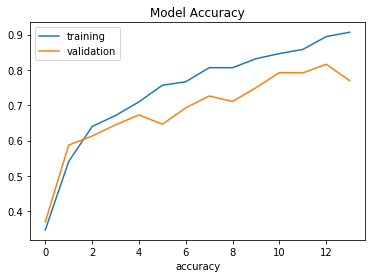

In [10]:
accuracies_train = pipeline.get_epoch_metric_train('accuracy')
accuracies_validation = pipeline.get_epoch_metric_validation('accuracy')

plot_metric(accuracies_train, accuracies_validation, xlabel='epoch', ylabel='accuracy', title='Model Accuracy')

# Visualize Loss

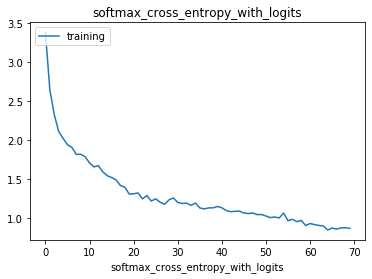

In [11]:
loss = pipeline.get_step_by_name('TensorflowV1ModelStep').loss
plot_metric(loss, xlabel='batch', ylabel='softmax_cross_entropy_with_logits', title='softmax_cross_entropy_with_logits')

# Save pipeline

In [12]:
pipeline.save(ExecutionContext(DEFAULT_CACHE_FOLDER))

AttributeError: 'DeepLearningPipeline' object has no attribute 'steps_as_tuple'

# Serve Rest Api

In [13]:
pipeline = HumanActivityRecognitionPipeline()

pipeline = pipeline.load(ExecutionContext(DEFAULT_CACHE_FOLDER))

AttributeError: module '__main__' has no attribute 'ClassificationRNNTensorFlowModel'

In [ ]:
app = FlaskRestApiWrapper(
    json_decoder=CustomJSONDecoderFor2DArray(),
    wrapped=pipeline,
    json_encoder=CustomJSONEncoderOfOutputs()
).get_app()

app.run(debug=False, port=5000)